In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
from datetime import datetime
import tensorflow
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [102]:
pip install xlrd

  Using cached xlrd-2.0.1-py2.py3-none-any.whl (96 kB)
Note: you may need to restart the kernel to use updated packages.


### Preparing the dataset for the time serie analysis

In [111]:
data = pd.read_excel('data_nestlé.xls')
df = pd.DataFrame(data)
df.dtypes

Date           datetime64[ns]
Dernier               float64
Ouv.                  float64
 Plus Haut            float64
Plus Bas              float64
Vol. ()               float64
Variation %           float64
dtype: object

In [112]:
df.isna().sum()

Date           0
Dernier        0
Ouv.           0
 Plus Haut     0
Plus Bas       0
Vol. ()        1
Variation %    0
dtype: int64

In [121]:
df = df.rename(columns={"Date": "date", "Dernier": "close", 'Ouv.':'open', ' Plus Haut':'highest', 'Plus Bas':'lowest','Vol. ()':'volume','Variation %':'variation'})

In [123]:
df.describe()

,close,open,highest,lowest,volume,variation
count,2735.000000,2735.000000,2735.000000,2735.000000,2734.000000,2735.000000
mean,84.167360,84.130801,84.686296,83.625664,5.673734,0.000316
std,19.587153,19.564659,19.760020,19.417801,3.478339,0.009777
min,52.750000,52.750000,53.150000,52.500000,1.210000,-0.068300
25%,69.400000,69.350000,69.750000,68.925000,3.920000,-0.004800
50%,77.200000,77.120000,77.500000,76.680000,5.000000,0.000200
75%,103.870000,103.760000,104.610000,102.970000,6.410000,0.005600
max,129.660000,129.500000,129.800000,128.280000,87.280000,0.059100


In [148]:
df = df.sort_values(by=['date']).reset_index(drop=True)

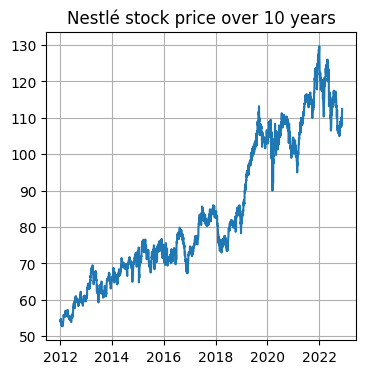

In [163]:
x = df['date']
y = df['close']
plt.figure(figsize=(4, 4))
plt.title('Nestlé stock price over 10 years')
plt.grid(True)
plt.plot(x,y)

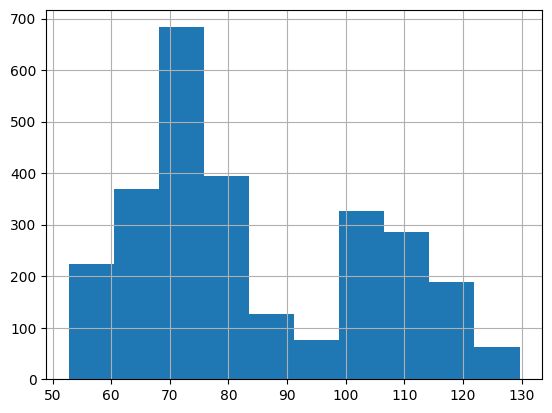

In [164]:
y.hist()
plt.show()

### Checking the stationarity of this time serie

In [204]:
# spliting the data into 5 chunks
chunks = np.split(y, indices_or_sections=5)
print(np.mean(chunks, axis=1))
print(np.var(chunks, axis=1))

[ 61.34250457  71.39296161  77.70265082  97.97808044 112.42060329]
[ 18.11759464   6.63990019  18.89990943 103.82259065  55.16800823]


In [205]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(y)

In [206]:
print(pvalue)

0.7265268573666983


We fail to reject the null hypothesis, meaning the dataset is non stationary.

#### The mean and the variance of the serie is clearly changing over time which means it isn't stationary.

### Analyzing the correlogram

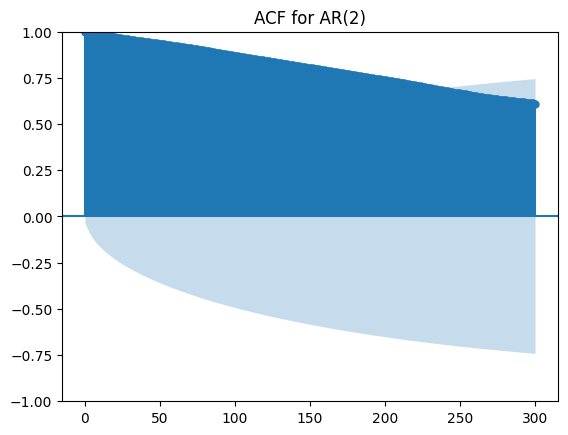

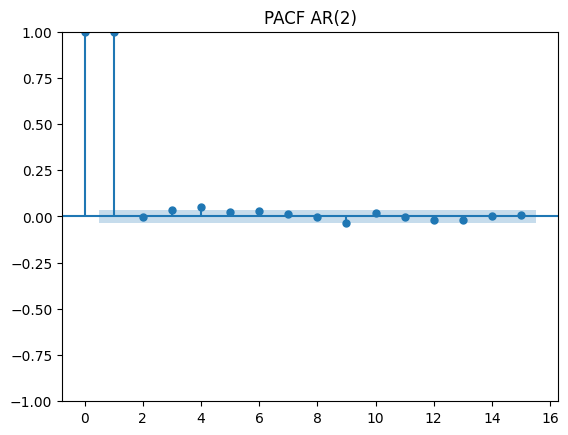

In [223]:
# Autocorrelation for AR(2)
acf_plot = plot_acf(y, lags=300, title='ACF for AR(2)')
# partial Autocorrelation for AR(2)
pacf_plot = plot_pacf(y, lags=15, title='PACF AR(2)')

#### We notice that the ACF does not gradually decrease to zero and that the PACF cuts off after lag 1, mainly due to the time serie not being stationnary. In the current state, no inference could be made on the next stock variation. 

### Decomposing the time serie

The decomposition is primarily used for time series analysis. It provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model.

The idea of multiplicative decomposition is the following:

1. Estimate the trend component $\hat{T}_{t}$ using the Moving Average.
2. Calculate the detrended series by $y_{t}/\hat{T}_{t}$.
3. Estimate the seasonal component $\hat{S}_{t}$ by calculing the simple average on the detrended series for each season.
4. Estimate the residuals component $\hat{R}_{t}$ by $\frac{y_{t}}{\hat{T}_{t}*\hat{S}_{t}}$.

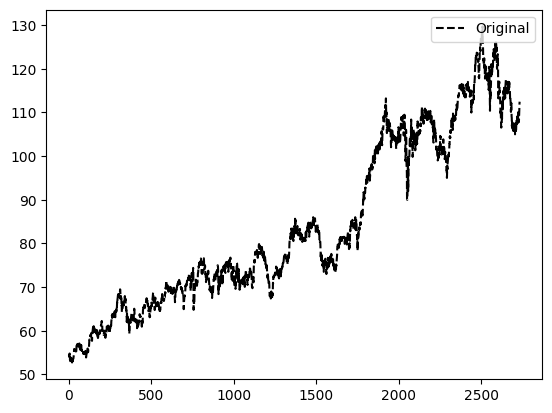

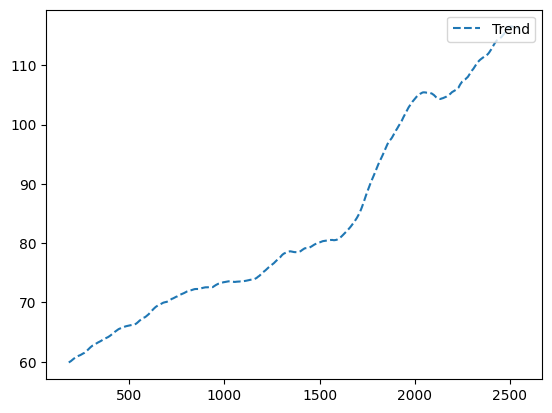

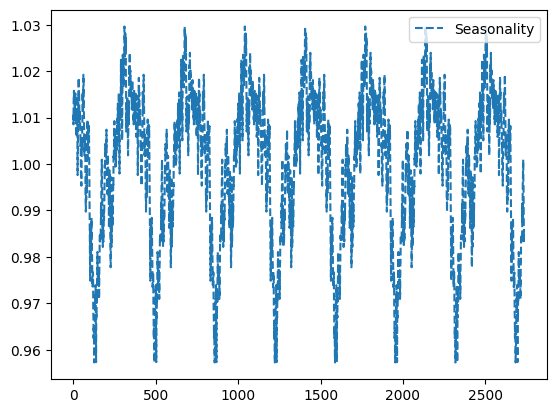

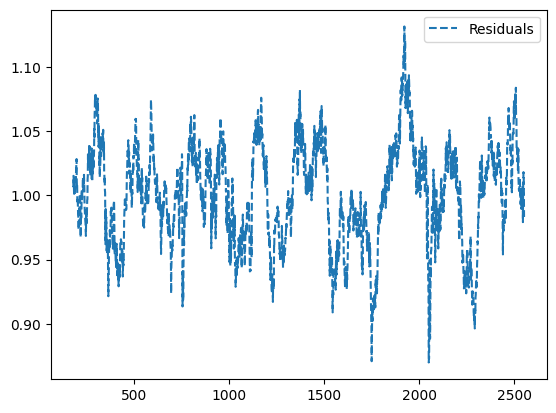

In [211]:
result = seasonal_decompose(x=y, model='multiplicative',period=365)
plt.plot(result.observed,'k',linestyle='dashed',label='Original')
plt.legend(loc='upper right')
plt.show()
plt.plot(result.trend,linestyle='dashed', label='Trend')
plt.legend(loc='upper right')
plt.show()
plt.plot(result.seasonal,linestyle='dashed', label='Seasonality')
plt.legend(loc='upper right')
plt.show()
plt.plot(result.resid,linestyle='dashed',label='Residuals')
plt.legend(loc='upper right')
plt.show()

#### The decomposition of the multiplicative model is quite representative regarding trend.

### Making the time serie stationnary

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. However, the moving average model requires stationnarity from the data. Thus, we need to find a way to transform the data.

### ML model "à définir"